In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn import preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import math, time

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [ ]:
submissions = pd.read_csv('submissions.csv')
comments = pd.read_csv('comments.csv')

In [ ]:
import datetime
import time
from datetime import datetime, timedelta
def ceil_dt(dt):
    #round down to the closest half of hour
    delta = timedelta(minutes=30)
    format = "%Y-%m-%d %H:%M:%S"
    dt = datetime.strptime(time.strftime(format, time.localtime(dt)), format)
    return dt + (datetime.min - dt) % delta

submissions['datetime'] = submissions['created_utc'].apply(ceil_dt)
comments['datetime'] = comments['created_utc'].apply(ceil_dt)

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

comments['sentiment'] = comments['body'].apply(lambda x: sid.polarity_scores(x))
comments_sentiment_df = pd.json_normalize(comments['sentiment'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
import pandas as pd
from keras import models
from keras import layers
import numpy as np

In [ ]:
subs = pd.DataFrame(columns=['neg','neu', 'pos','compound','date'])
subs[['neg','neu','pos','compound']] = comments_sentiment_df[['neg','neu','pos','compound']]
subs['date'] = comments['datetime']
subs = subs.groupby(['date']).mean()
subs = subs.reset_index()

In [ ]:
import yfinance as yf
GME = yf.download("GME", start="2020-12-10", end="2021-12-05", interval="1h")

[*********************100%***********************]  1 of 1 completed


In [ ]:
GME.shape

(1730, 6)

In [ ]:
GME = GME.rename(columns={"Open":"open", "High":"high", "Low":'low',"Adj Close":'close', "Volume":'volume'})
GME = GME.drop(["Close"], axis=1)

In [ ]:
GME.head()

,open,high,low,close,volume
2020-12-10 09:30:00,13.180,14.1000,13.13,13.8800,2597921
2020-12-10 10:30:00,13.880,14.0589,13.61,13.7500,1075940
2020-12-10 11:30:00,13.745,13.8200,13.60,13.7100,490607
2020-12-10 12:30:00,13.705,13.9500,13.70,13.9300,365460
2020-12-10 13:30:00,13.940,13.9500,13.85,13.9389,468805


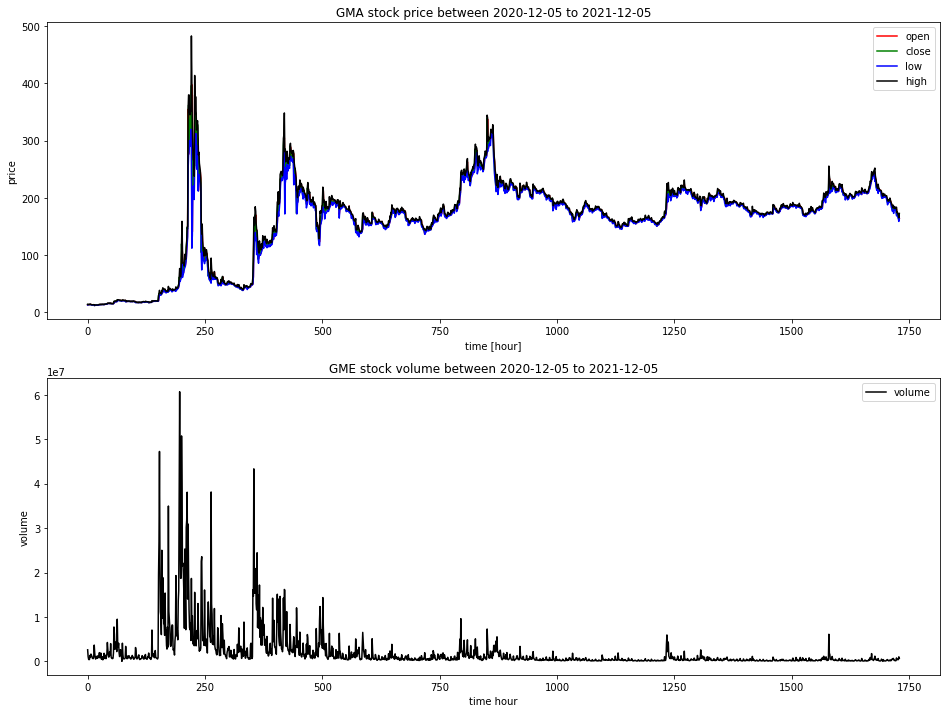

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.plot(GME.open.values, color='red', label='open')
plt.plot(GME.close.values, color='green', label='close')
plt.plot(GME.low.values, color='blue', label='low')
plt.plot(GME.high.values, color='black', label='high')
plt.title('GMA stock price between 2020-12-05 to 2021-12-05')
plt.xlabel('time [hour]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(GME.volume.values, color='black', label='volume')
plt.title('GME stock volume between 2020-12-05 to 2021-12-05')
plt.xlabel('time hour')
plt.ylabel('volume')
plt.legend(loc='best');

In [ ]:
GME.describe()

,open,high,low,close,volume
count,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03
mean,161.984306,165.776530,158.357431,161.787009,2.046727e+06
std,68.869216,71.098260,66.815250,68.616177,4.715100e+06
min,12.203200,12.528900,12.140000,12.200000,0.000000e+00
25%,150.562496,153.785000,148.264999,150.467503,2.557800e+05
50%,177.809998,180.535004,175.725052,177.964951,5.717305e+05
75%,203.692497,206.462502,201.097500,203.514679,1.555817e+06
max,397.859985,483.000000,320.000000,396.505005,6.069506e+07


In [ ]:
sub_df = pd.DataFrame(columns=['neg','neu', 'pos','compound'])
date = []
i = 0
while i < len(subs):
    sub_df.loc[len(sub_df.index)] = subs.iloc[i:i+2].mean()
    date.append(subs.iloc[i]['date'])
    i += 2

sub_df['date'] = date
sub_df = sub_df.set_index(['date'])

<ipython-input-19-602dc22331d7>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  sub_df.loc[len(sub_df.index)] = subs.iloc[i:i+2].mean()


In [ ]:
sub_df.head()

,neg,neu,pos,compound
date,,,,
2020-12-15 05:30:00,0.071111,0.808589,0.120344,-0.053648
2020-12-15 06:30:00,0.081223,0.828571,0.090205,0.066261
2020-12-15 07:30:00,0.118167,0.827083,0.054667,-0.027850
2020-12-15 08:30:00,0.027357,0.837500,0.135143,0.163293
2020-12-15 09:30:00,0.071250,0.781167,0.147750,0.161538


In [ ]:
df = sub_df.join(GME, how='inner')

In [ ]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    return df
#df = normalize_data(df)
#df.head()
GME = normalize_data(GME)

def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [ ]:
#LSTM
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mean_squared_error',optimizer='rmsprop', metrics=['mean_squared_error'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
#GRU
from keras.layers import GRU
def build_model(layers):
    d = 0.5
    model = Sequential()
    
    model.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mean_squared_error',optimizer='rmsprop', metrics=['mean_squared_error'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
#window = 22
#X_train, y_train, X_test, y_test = load_data(df, window)
window=50
X_train, y_train, X_test, y_test = load_data(GME, window)

In [ ]:
X_train.shape

(1511, 50, 5)

In [ ]:
model = build_model([5,window,1])

Compilation Time :  0.009124517440795898


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               201984    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 210,241
Trainable params: 210,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,batch_size=100,epochs=30,validation_split=0.1, verbose=0)

In [ ]:
p = model.predict(X_test)

6/6 [==============================] - 1s 40ms/step


In [ ]:
def denormalize(df, normalized_value): 
    df = df['close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

#newp = denormalize(df, p)
#newy_test = denormalize(df, y_test)
newp = denormalize(GME, p)
newy_test = denormalize(GME, y_test)

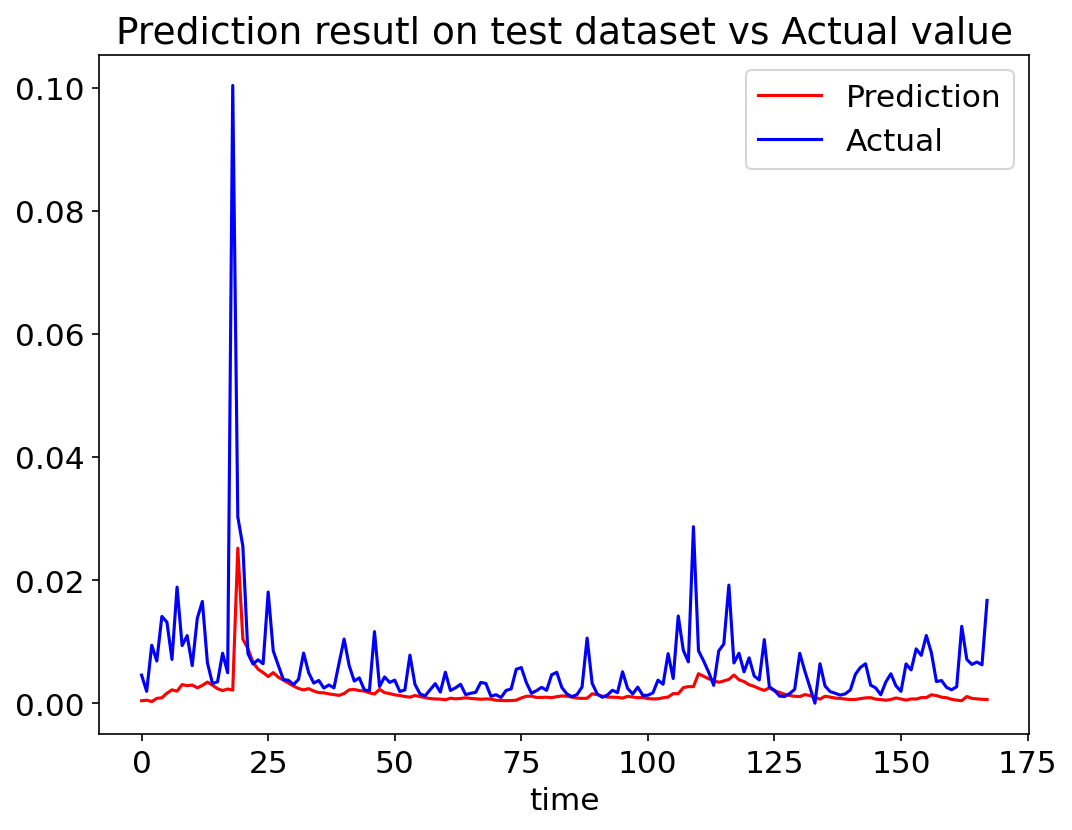

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8,6), dpi = 150)
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.title("Prediction resutl on test dataset vs Actual value")
plt.legend(loc='best')
plt.xlabel('time')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
def report(history,I_PLOT=True):

    print("---------------------------------------------------------------------")
    print("TRAIN METRIC (loss,mean_squared_error):",[history.history['loss'][-1],history.history['mean_squared_error'][-1]])
    print("VALIDATION METRIC (loss,mean_squared_error):",[history.history['val_loss'][-1],history.history['val_mean_squared_error'][-1]])
    #print(title+": TEST METRIC (loss,mean_squared_error):",t)
    print("---------------------------------------------------------------------")

    if(I_PLOT):
        epochs = range(1, len(history.history['loss']) + 1)
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1);
        plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
        plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
        plt.title("training and validation loss")
        plt.legend()

        plt.subplot(2,1,2);
        plt.plot(epochs, history.history['mean_squared_error'], 'ro', label='Training mean_squared_error')
        plt.plot(epochs, history.history['val_mean_squared_error'], 'r', label='Validation mean_squared_error')
        plt.title("training and validation mean squared error")
        plt.legend()
        plt.show()
        #plt.savefig('HISTORY-'+title+'.png')   # save the figure to file
        #plt.close()

---------------------------------------------------------------------
TRAIN METRIC (loss,mean_squared_error): [0.003267273772507906, 0.003267273772507906]
VALIDATION METRIC (loss,mean_squared_error): [2.3386557586491108e-05, 2.3386557586491108e-05]
---------------------------------------------------------------------


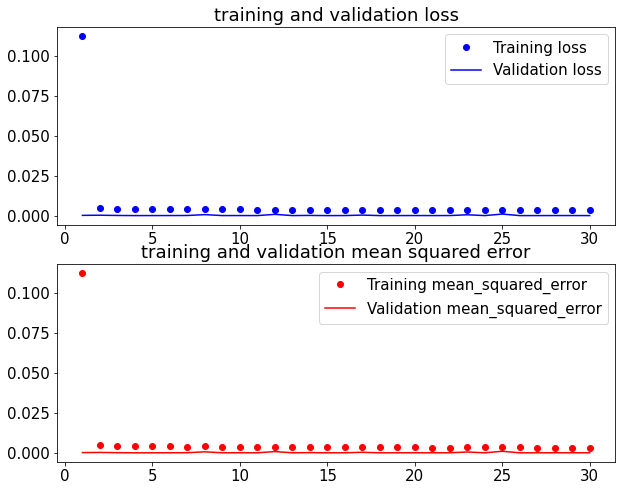

In [ ]:
report(history)